# Initilization

In [80]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("seaborn-whitegrid")
matplotlib.rcParams.update({'font.size': 15})

## Useful references

Ref.:

https://en.wikipedia.org/wiki/Ion_channel

http://book.bionumbers.org/how-many-ions-pass-through-an-ion-channel-per-second/

https://www.nature.com/articles/s42003-019-0729-3

https://journals.physiology.org/doi/full/10.1152/advan.00006.2002

Take away:

| a|b|
|-|-|
|<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Ion_channel.png" width="250"/> | <img src="http://book.bionumbers.org/wp-content/uploads/2014/08/427-f1-ChannelOpenClose-11.png" width="300"/>|

|c|
|-|
|<img src="http://book.bionumbers.org/wp-content/uploads/2014/08/427-f3-IonChannelCalc-1.png" width="560"/>|


- The opening of an ion channel is a fleeting event within a few milliseconds

- Single-channel records can be obtained using the appropriate electrophysiological technique (e.g., patch clamp), and from these records the open probability and the channel conductance can be calculated. 

- 

## Load data

In [7]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_submit = pd.read_csv('./data/sample_submission.csv')

## Exploratory data analysis (EDA)

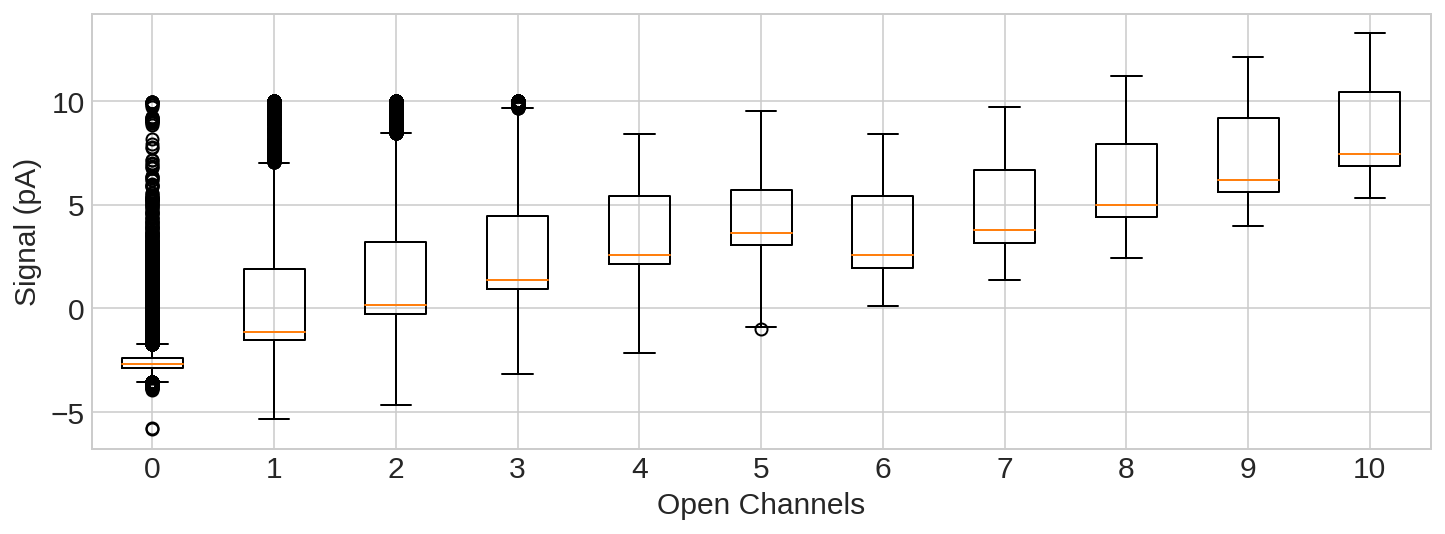

In [81]:
def boxplot_channel(df_train):
    # check quantiles of open channels corresponding to signal
    fig, ax = plt.subplots(1, 1, figsize= (12, 4))
    
    signal = []
    # sort number of channels
    n_channel = np.sort(df_train.open_channels.unique())
    
    # boxplots
    for val in n_channel:
        signal.append(df_train[df_train.open_channels == val].signal)
        
    ax.boxplot(signal)
    ax.set_xticklabels(n_channel)
    ax.set_xlabel('Open Channels')
    ax.set_ylabel('Signal (pA)')

    plt.show()

boxplot_channel(df_train)

Number of training batches: 10.0
Signal Batch:  0


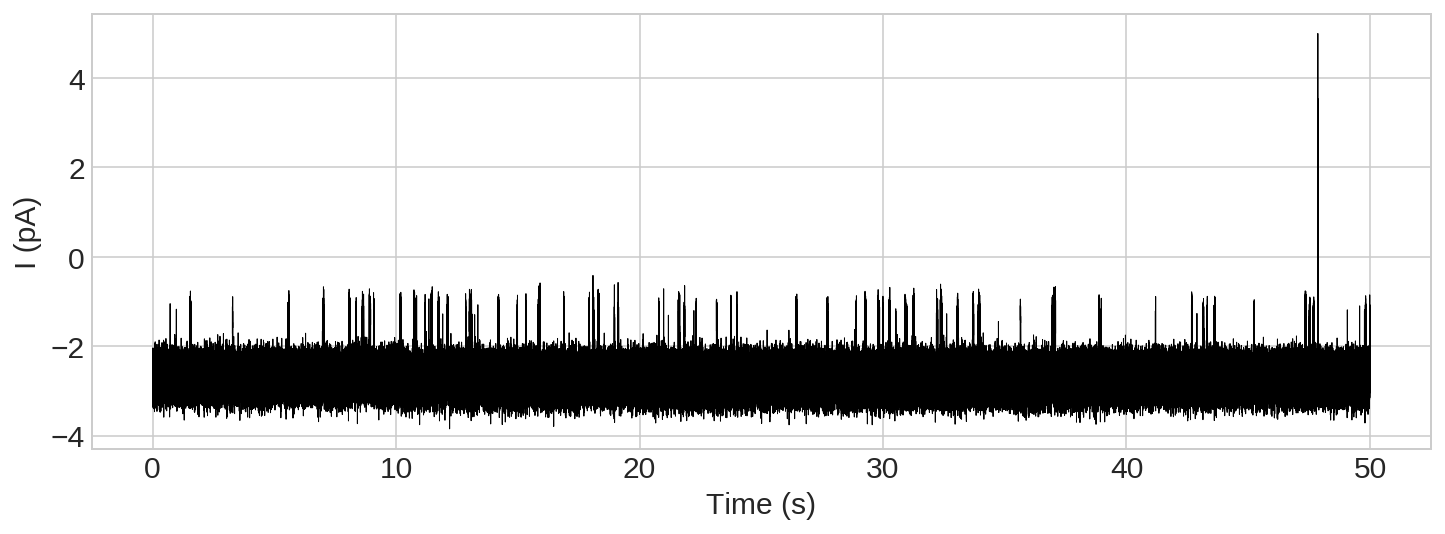

Signal Batch:  1


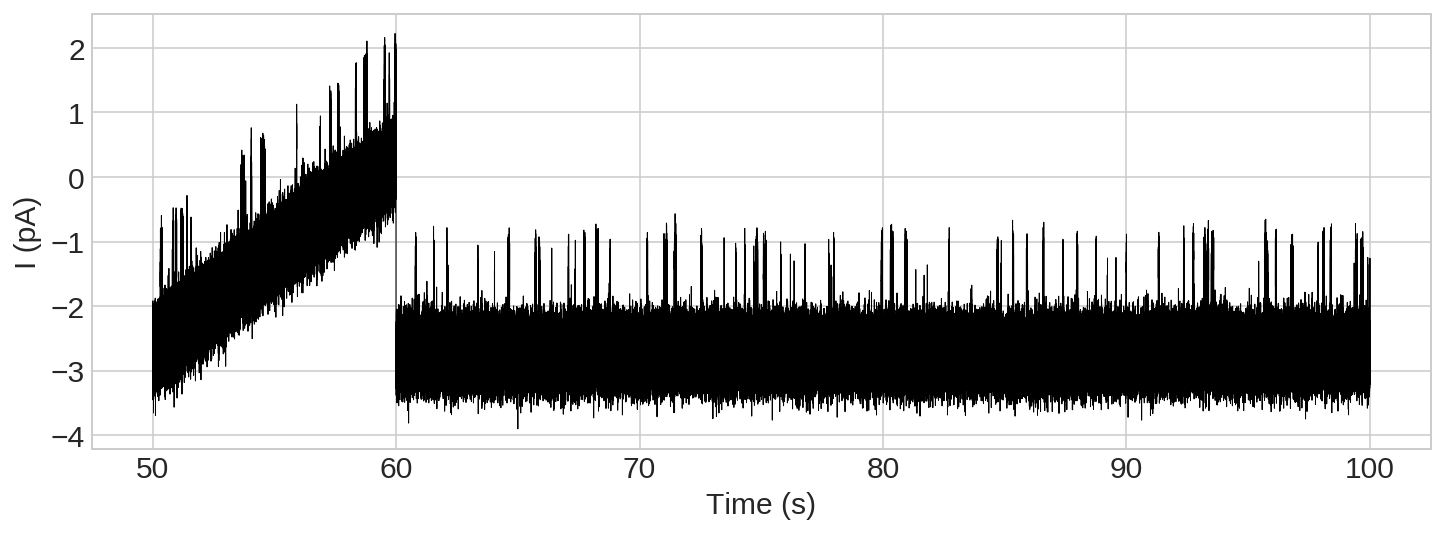

Signal Batch:  2


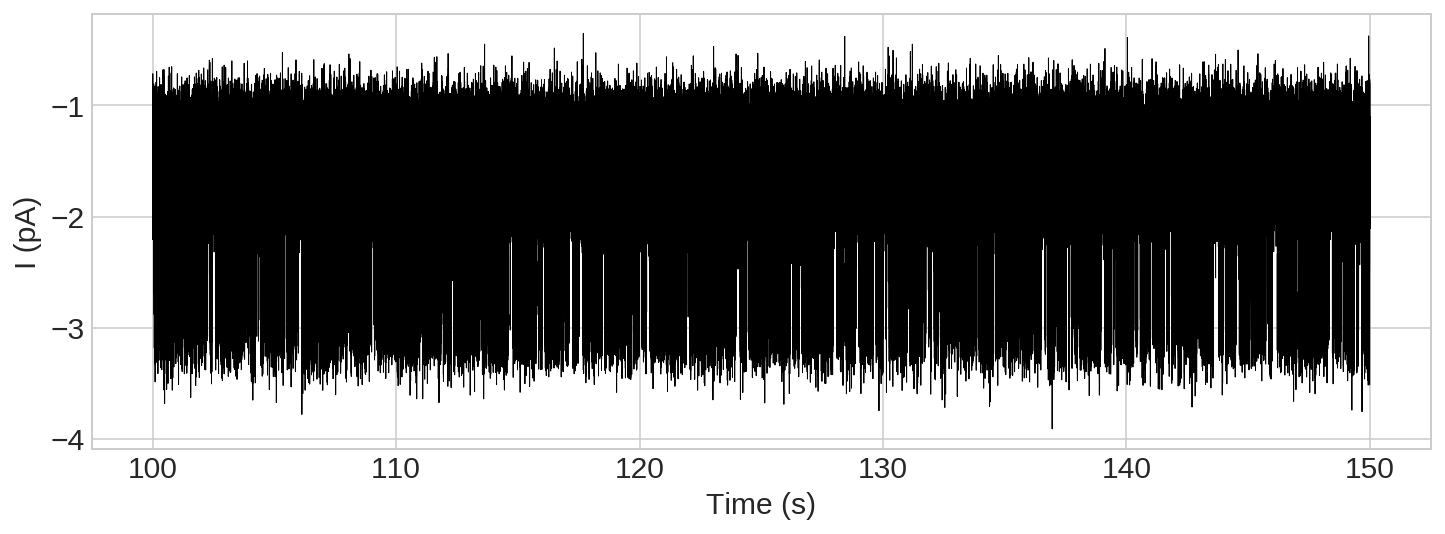

Signal Batch:  3


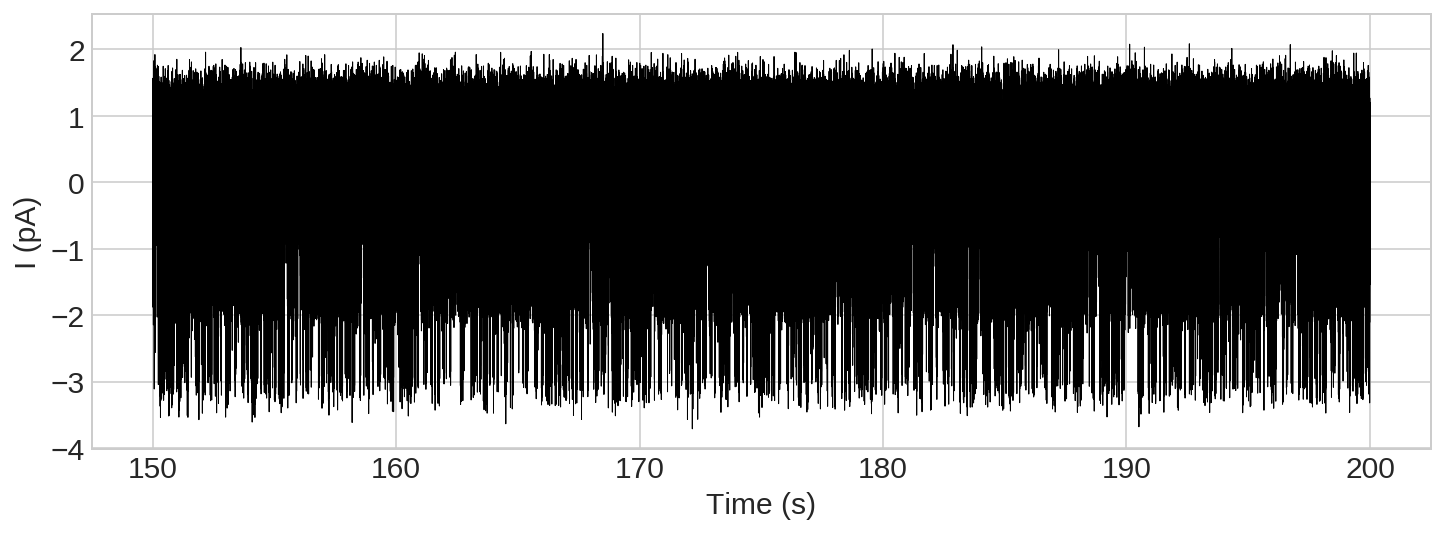

Signal Batch:  4


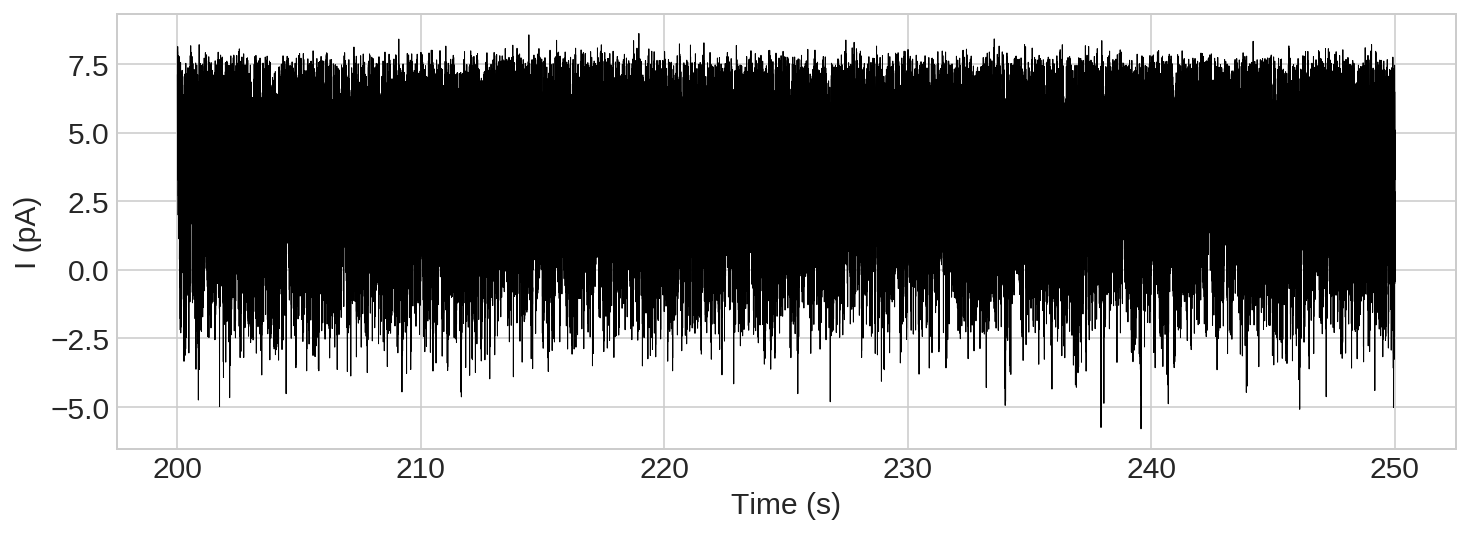

Signal Batch:  5


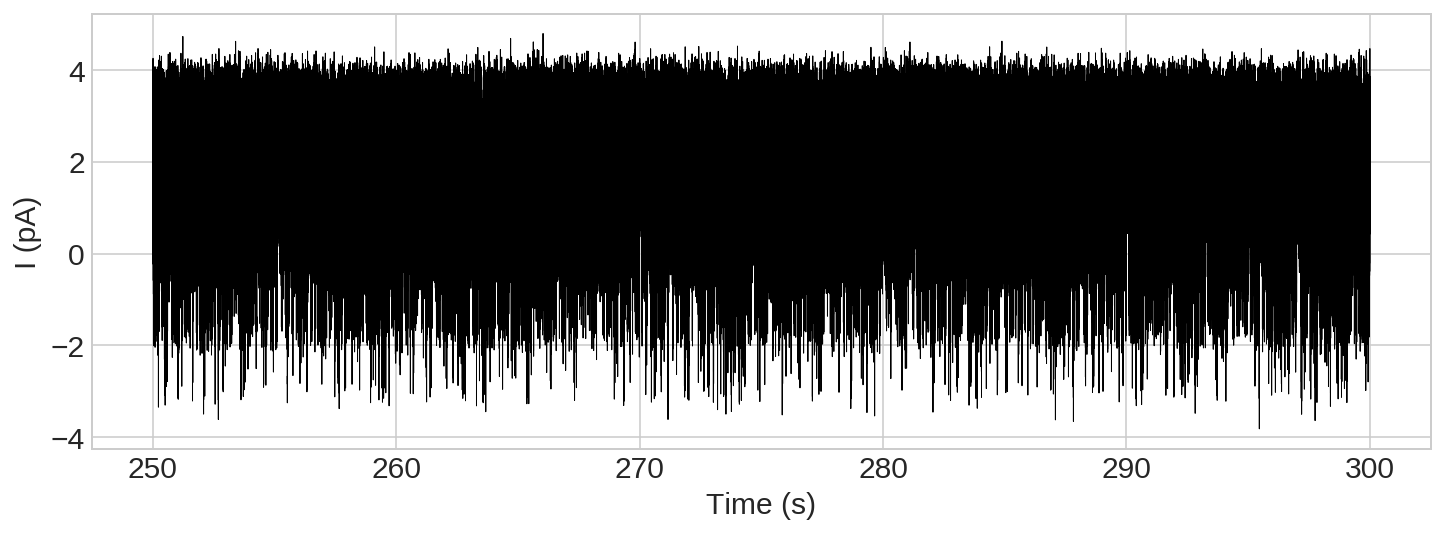

Signal Batch:  6


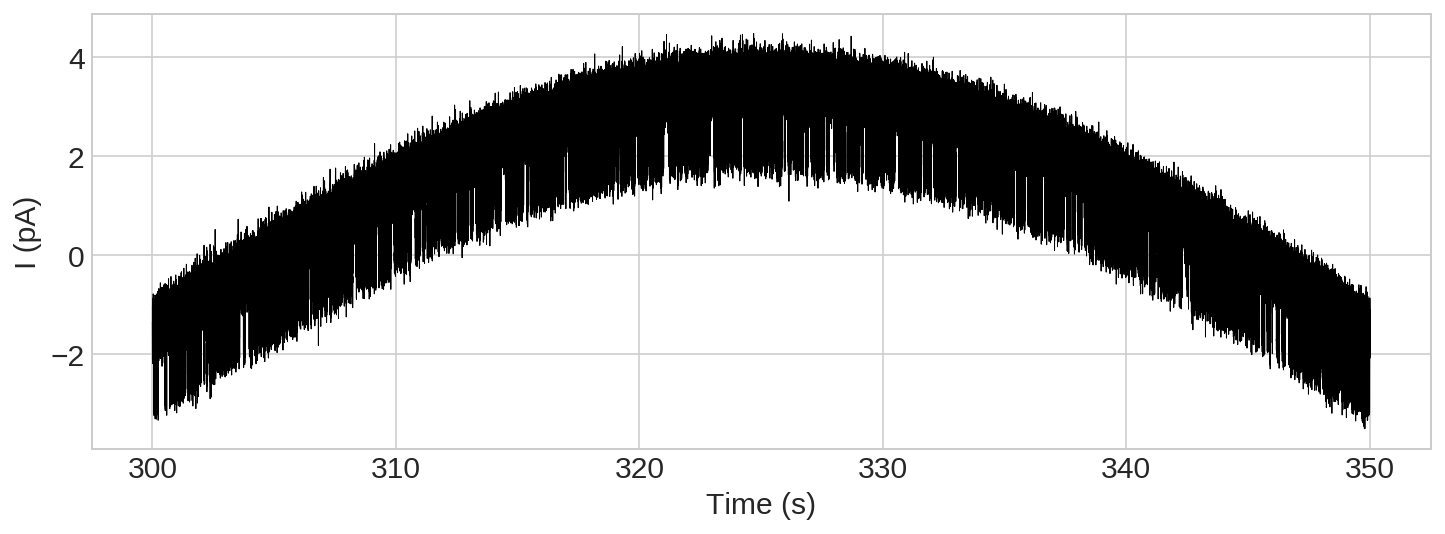

Signal Batch:  7


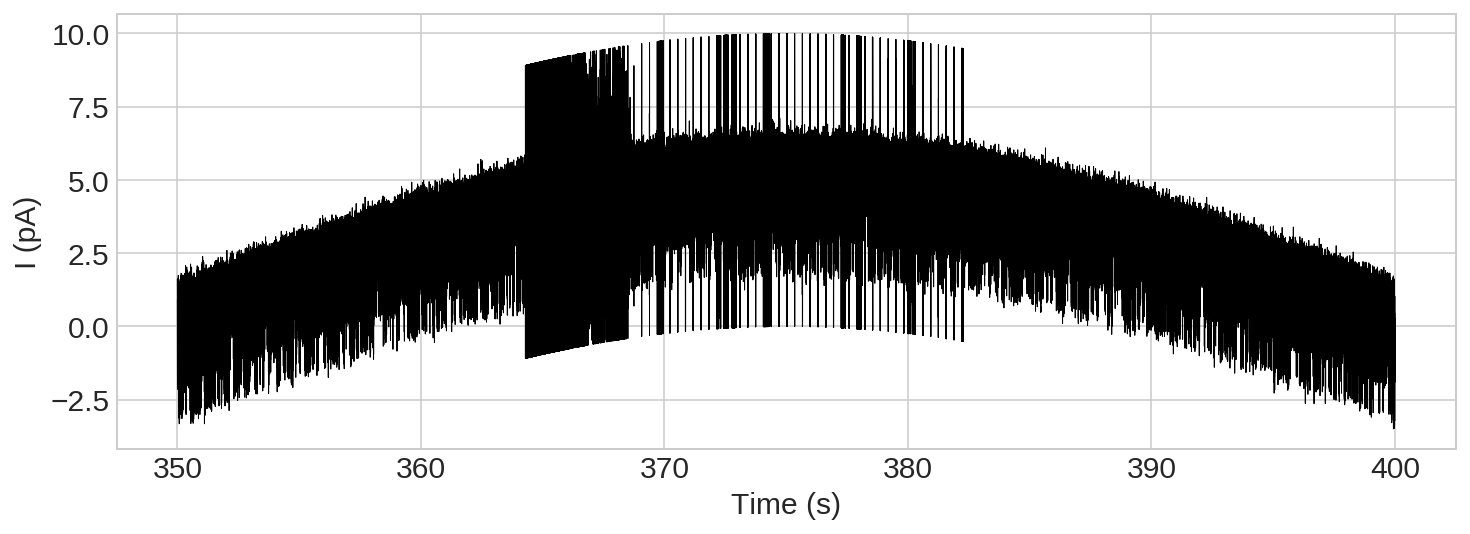

Signal Batch:  8


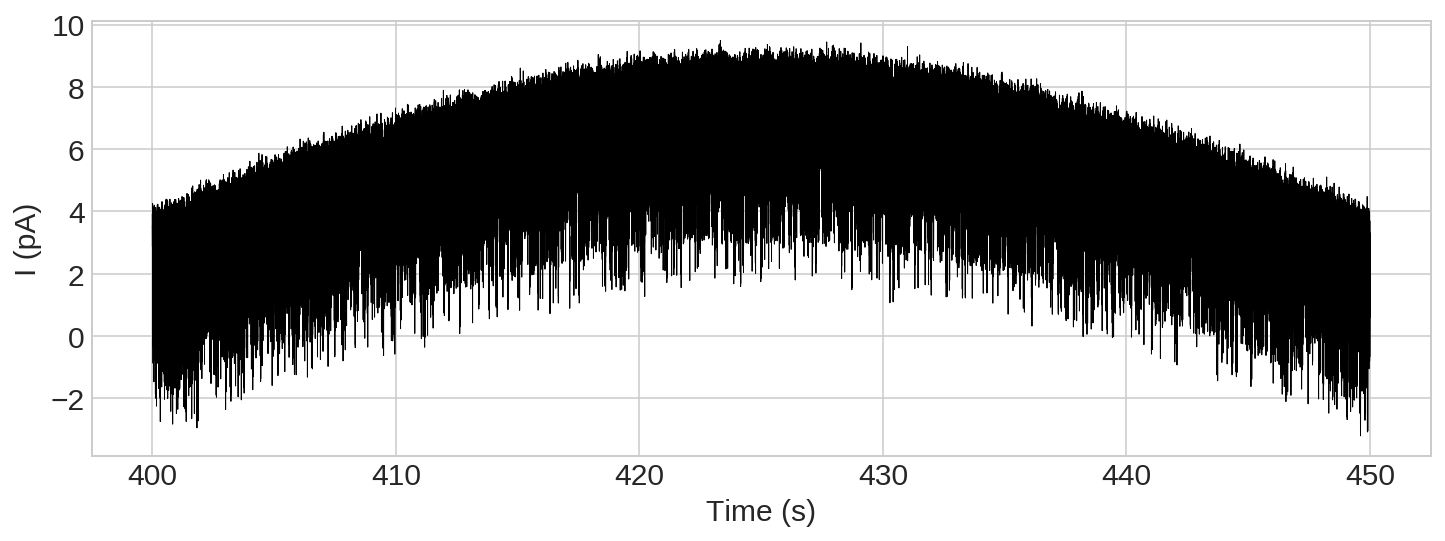

Signal Batch:  9


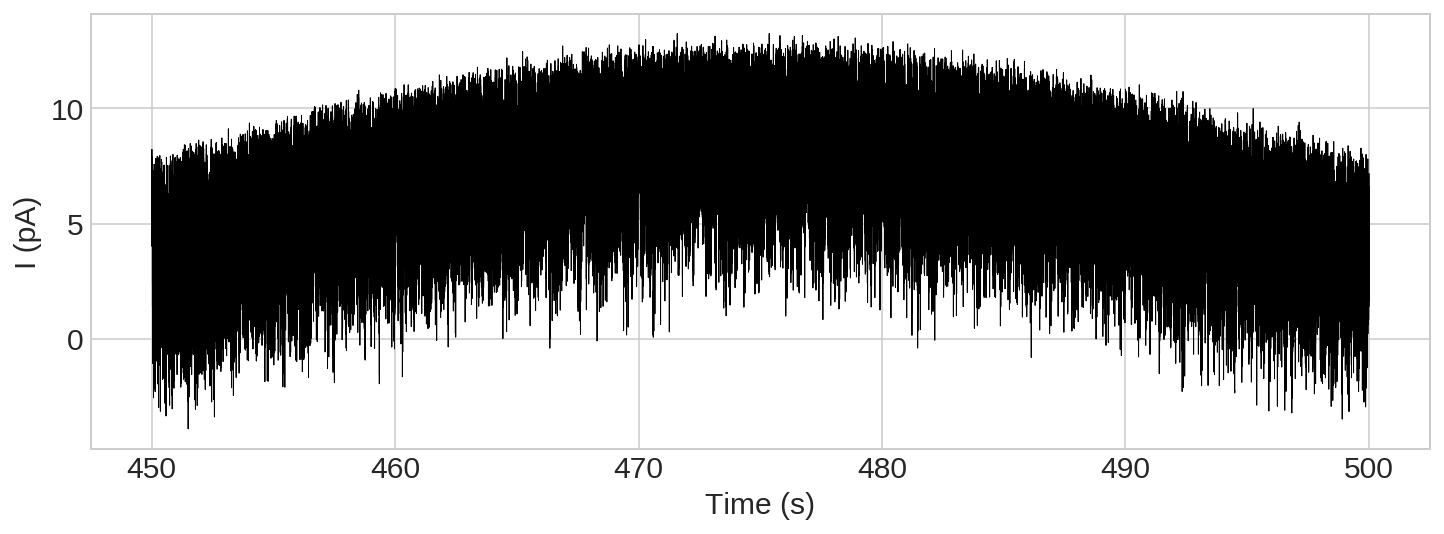

In [79]:
print('Number of training batches:', len(df_train)/500000)

for i in range(int(len(df_train)/500000)):
    print('Signal Batch: ', i)
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.plot(df_train['time'].iloc[i*500000:(i+1)*500000], 
            df_train['signal'].iloc[i*500000:(i+1)*500000],
            'k', lw=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('I (pA)')
    plt.show()

In [29]:
print('Number of testing batches:', len(df_test)/500000)
df_test.head()

Number of testing batches: 4.0


,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [24]:
len(df_submit)/500000

4.0